# **<center> <span style="color: pink;">ATML PA_0 </span>**

### <span style="color: DeepPink;"> Name : Khadeeja Toseef </span>
### <span style="color: DeepPink;"> Roll Number : 27100309 </span>

## <center> <span style="color: pink;">Task 5: Modality Gap in CLIP </span>

### <span style="color: HotPink;"> 1. Zero-Shot Classification on STL-10
</span>

<span style="color: MediumPurple;"> (a) Download the STL-10 dataset from torchvision.
</span>

<span style="color: #D8BFD8;">importing libraries </span>

In [16]:
# !pip install clip
!pip uninstall -y clip
!pip install git+https://github.com/openai/CLIP.git
import os
import umap
import clip
import torch
import torchvision

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
from torchvision.datasets import STL10
from tqdm import tqdm
# from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

Found existing installation: clip 1.0
Uninstalling clip-1.0:
  Successfully uninstalled clip-1.0
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-80pfw46o
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-80pfw46o
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=790c698dd0e339d4172d84c759549d7eda8e146ac1205432292b994024b6ec9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-9s2nr6iw/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [2]:
print(dir(clip))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'available_models', 'clip', 'load', 'model', 'simple_tokenizer', 'tokenize']


In [4]:

# Load CLIP preprocessing pipeline
_, preprocess = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=preprocess)
testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=preprocess)

dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print("STL-10 dataset downloaded.")

STL-10 dataset downloaded.


<span style="color: MediumPurple;"> (b) Load OpenAI’s CLIP model from the official implementation of clip.
</span>

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [6]:
classnames = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

<span style="color: MediumPurple;"> (c) Evaluate clip for zero-shot accuracy on STL-10 using different prompting techniques:
</span>   

<span style="color: MediumPurple;"> i. Plain labels (e.g., “cat”).
</span>  

In [7]:
plain_text_prompts = classnames

# tokenize prompts
text_inputs = torch.cat([clip.tokenize(label) for label in plain_text_prompts]).to(device)

# encode prompted text features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize

# evaluate zero-shot classification with prompted text
correct = 0
total = 0

print("\nEvaluating Zero-Shot Accuracy on STL-10 (Plain Prompts)...")

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # encode image features
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # compute similarity (cosine) between image and text features
        similarity = (100.0 * image_features @ text_features.T)  # shape: [batch_size, num_classes]
        predictions = similarity.argmax(dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Final accuracy
accuracy = 100 * correct / total
print(f"\nZero-Shot Accuracy with Plain Labels: {accuracy:.2f}%")



Evaluating Zero-Shot Accuracy on STL-10 (Plain Prompts)...


100%|██████████| 125/125 [22:00<00:00, 10.57s/it]


Zero-Shot Accuracy with Plain Labels: 96.25%


<span style="color: MediumPurple;"> ii. Prompted text (e.g., “a photo of a cat”).
</span>   

In [9]:
prompted_text_prompts = [f"a photo of a {label}" for label in classnames]

# tokenize prompts
text_inputs_prompted = torch.cat([clip.tokenize(p) for p in prompted_text_prompts]).to(device)

# encode prompted text features
with torch.no_grad():
    text_features_prompted = model.encode_text(text_inputs_prompted)
    text_features_prompted /= text_features_prompted.norm(dim=-1, keepdim=True)

# evaluate zero-shot classification with prompted text
correct_prompted = 0
total_prompted = 0

print("\nEvaluating Zero-Shot Accuracy on STL-10 (Prompted Text: 'a photo of a <label>')...")

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features_prompted.T)
        predictions = similarity.argmax(dim=1)

        correct_prompted += (predictions == labels).sum().item()
        total_prompted += labels.size(0)

accuracy_prompted = 100 * correct_prompted / total_prompted
print(f"\nZero-Shot Accuracy with Prompted Text ('a photo of a <label>'): {accuracy_prompted:.2f}%")



Evaluating Zero-Shot Accuracy on STL-10 (Prompted Text: 'a photo of a <label>')...


100%|██████████| 125/125 [21:35<00:00, 10.37s/it]


Zero-Shot Accuracy with Prompted Text ('a photo of a <label>'): 97.36%


<span style="color: MediumPurple;"> iii. More descriptive variants of prompts.
</span>

In [10]:
# ----------- (iii) More Descriptive Prompts -----------
descriptive_prompts = [f"a high-resolution photo of a cute {label} in nature" for label in classnames]

# Tokenize descriptive prompts
text_inputs_desc = torch.cat([clip.tokenize(p) for p in descriptive_prompts]).to(device)

# Encode text features for descriptive prompts
with torch.no_grad():
    text_features_desc = model.encode_text(text_inputs_desc)
    text_features_desc /= text_features_desc.norm(dim=-1, keepdim=True)

# Evaluate with descriptive prompts
correct_desc = 0
total_desc = 0

print("\nEvaluating Zero-Shot Accuracy on STL-10 (Descriptive Prompts)...")

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features_desc.T)
        predictions = similarity.argmax(dim=1)

        correct_desc += (predictions == labels).sum().item()
        total_desc += labels.size(0)

accuracy_desc = 100 * correct_desc / total_desc
print(f"\nZero-Shot Accuracy with Descriptive Prompts: {accuracy_desc:.2f}%")



Evaluating Zero-Shot Accuracy on STL-10 (Descriptive Prompts)...


100%|██████████| 125/125 [20:31<00:00,  9.85s/it]


Zero-Shot Accuracy with Descriptive Prompts: 96.26%


<span style="color: MediumPurple;"> (d) You can experiment with the prompts on a small subset. However, you are to compare accuracies across atleast 3 different prompting strategies for the whole test set
</span>

In [11]:
print("\n==== Zero-Shot Accuracy Comparison on STL-10 ====")
print(f"Plain labels           : {accuracy:.2f}%")
print(f"Prompted ('a photo of'): {accuracy_prompted:.2f}%")
print(f"Descriptive prompts    : {accuracy_desc:.2f}%")


==== Zero-Shot Accuracy Comparison on STL-10 ====
Plain labels           : 96.25%
Prompted ('a photo of'): 97.36%
Descriptive prompts    : 96.26%


### <span style="color: HotPink;"> 2. Exploring the Modality Gap
</span>

<span style="color: MediumPurple;"> (a) Use the vision and text model within CLIP to extract image and label embeddings from CLIP for a few (50-100) STL-10 samples.
</span>

In [12]:
# Extract image and text embeddings for a subset of STL-10 samples

num_samples = 100  # Number of samples to use
subset_indices = np.random.choice(len(testset), num_samples, replace=False)
subset_testset = torch.utils.data.Subset(testset, subset_indices)
subset_dataloader = DataLoader(subset_testset, batch_size=32, shuffle=False, num_workers=2)

image_embeddings = []
labels_list = []

print(f"\nExtracting image embeddings for {num_samples} samples...")
with torch.no_grad():
    for images, labels in tqdm(subset_dataloader):
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_embeddings.append(image_features.cpu())
        labels_list.append(labels.cpu())

image_embeddings = torch.cat(image_embeddings)
labels_list = torch.cat(labels_list)

# Extract text embeddings for class names
text_inputs = torch.cat([clip.tokenize(label) for label in classnames]).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_inputs)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

print("Image and text embeddings extracted.")


Extracting image embeddings for 100 samples...


100%|██████████| 4/4 [00:23<00:00,  6.00s/it]


Image and text embeddings extracted.


<span style="color: MediumPurple;"> (b) Use dimensionality reduction techniques such as UMAP or t-SNE to project the embeddings into 2D space.
</span>

In [17]:
# Concatenate image and text embeddings for dimensionality reduction
all_embeddings = torch.cat([image_embeddings, text_embeddings])
all_labels = torch.cat([labels_list, torch.arange(len(classnames)) + len(torch.unique(labels_list))]) # Assign unique labels to text embeddings

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(all_embeddings)

# Separate reduced embeddings
reduced_image_embeddings = reduced_embeddings[:len(image_embeddings)]
reduced_text_embeddings = reduced_embeddings[len(image_embeddings):]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<span style="color: MediumPurple;"> (c) Visualize and compare the distributions of text and image embeddings.
</span>

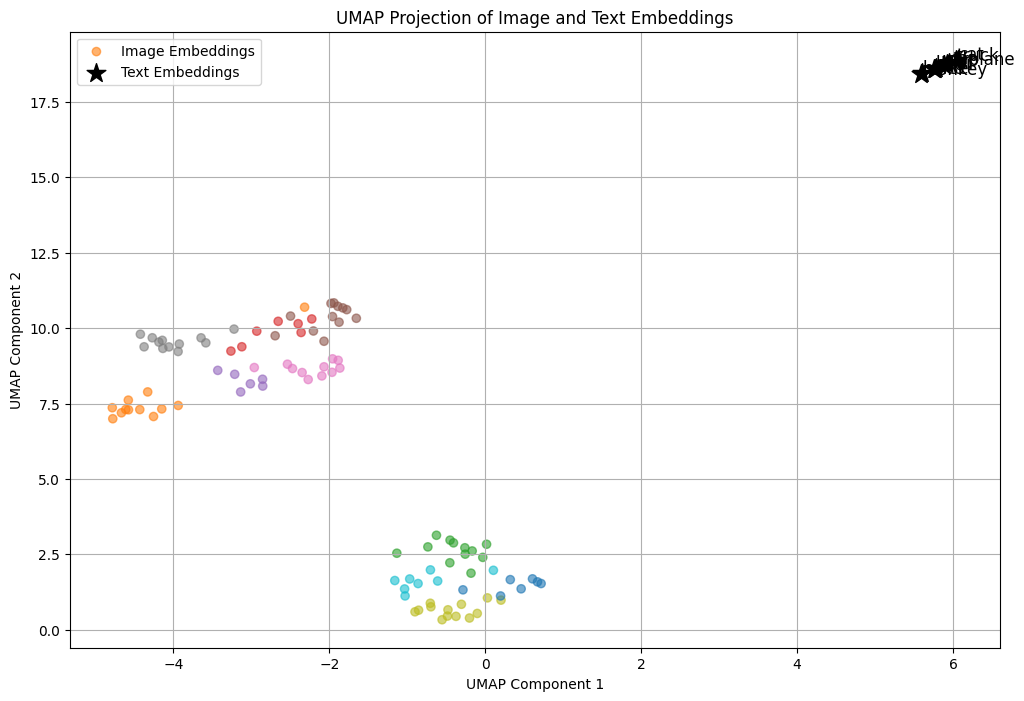

In [18]:
# Visualize the reduced embeddings
plt.figure(figsize=(12, 8))

# Plot image embeddings, colored by their class
scatter_image = plt.scatter(reduced_image_embeddings[:, 0], reduced_image_embeddings[:, 1],
                            c=labels_list, cmap='tab10', label='Image Embeddings', alpha=0.6)

# Plot text embeddings with distinct markers
scatter_text = plt.scatter(reduced_text_embeddings[:, 0], reduced_text_embeddings[:, 1],
                           marker='*', s=200, color='black', label='Text Embeddings')

# Add class names next to text embeddings
for i, label in enumerate(classnames):
    plt.text(reduced_text_embeddings[i, 0], reduced_text_embeddings[i, 1], label, fontsize=12)

plt.title('UMAP Projection of Image and Text Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)
plt.show()

<span style="color: MediumPurple;"> (d) Briefly explain your findings:
</span>

### <span style="color:DarkCyan;"> How separated are the modalities? Does normalization affect the modality gap? Why does CLIP still perform well despite this gap?
</span>

ANSWER = <span style="color: #D8BFD8;"> ... </span>

### <span style="color: HotPink;"> 3. Bridging the Modality Gap
</span>

<span style="color: MediumPurple;"> (a) One simple method to align modalities is the orthogonal Procrustes transform.
Given two sets of embeddings $X$ (image features) and $Y$ (text features),
the goal is to find an orthogonal matrix $R$ that minimizes:</span>
$$
\color{MediumPurple}{\min_{R} \; \| XR - Y \|_{F},}
$$
<span style="color: MediumPurple;">
where
</span>

$\| \cdot \|_{F}$

<span style="color: MediumPurple;">
is the Frobenius norm.
</span>
<span style="color: MediumPurple;">
The closed-form solution involves singular value decomposition (SVD),
but a library implementation will suffice for our case.
</span>

<span style="color: MediumPurple;"> (b) Pair STL-10 image embeddings with their corresponding text embeddings.
</span>

<span style="color: MediumPurple;"> (c) Learn the optimal rotation matrix R using a library implementation of Procrustes alignment (hint: scipy.linalg.orthogonal procrustes or equivalent).
</span>

<span style="color: MediumPurple;"> (d) Apply the rotation transform to the CLIP embeddings.
</span>

<span style="color: MediumPurple;"> (e) Visualize the aligned embeddings with t-SNE or UMAP. How does the alignment affect the modality
gap?
</span>

<span style="color: MediumPurple;"> (f) Recompute classification accuracy with the aligned embeddings and compare results with Part 0.
</span>